# Shape Free Reconstruction via Style Transfer Loss
## to Reconstruct Generated Image to get near the Ground truth ?

## ###############################################*100

# Prcoedure 
## Build Model
## Trainig in Batch
While Training:
    Pick Mask  image 
    Looping for n_iteration
        Pick batch_size images.
        Generate Images (# = batch_size
        Create Training Data 
        
        fit in NN to traing for 50 times 

End While till converge 




In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
from keras import Model

import matplotlib.pyplot as plt
import cv2
from random import randint
import subprocess

from keras.layers import Input,Conv2D,Subtract, Lambda
%matplotlib inline
from keras.models import load_model
import os
import keras.backend as K
import random
from random import randint
from shape_free_conv import build_model # model definition and build is here



Using TensorFlow backend.


# Build Model (4 layer fully convolution CNN)

## Will Change LOss structure..layer near out put should have larger loss .
## should have style loss (layer 1-4), content loss(layer4), reconstruction loss (output layer)
current: for  layer 1-4 , should use gram_ matrix as style loss, but bugs happen...use MSE instead

In [2]:
# crete label with ALL Zero's fo rlater fit usage
# The label list depends on batch_sie, channel, Height, width, and layer size
def create_label(batch_size,ch,H,W,n_layer=5):
    label = []
    for i in range (1,n_layer):
        label.append(np.zeros(shape=[batch_size,ch*i,ch*i]))
    label.append (np.zeros(shape=[batch_size,H,W,3]))
    return label

In [3]:
# Network model and loss

weight_list = [10.0]*4 + [1.0]
batch_size = 1 # define bacth_size
ch = 32

model = build_model(batch_size,ch)









    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 896         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 18496       conv2d_1[0][0]                   
          

In [4]:
# Toy example to check the imported model 
# Could skip

H = 2
W = 2

X_data = np.random.normal(size=[batch_size,H,W,3])
y_data = np.random.normal(size=[batch_size,H,W,3])


label = create_label(batch_size,ch,H,W,n_layer=5)


model.fit([X_data,y_data], label , epochs=20)


Epoch 1/20
1/1 [==============================] - 1s 621ms/step - loss: 1.8311 - subtract_1_loss: 0.1079 - subtract_2_loss: 0.0110 - subtract_3_loss: 0.0014 - subtract_4_loss: 1.7976e-04 - subtract_5_loss: 1.7107
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 1.1791 - subtract_1_loss: 0.1021 - subtract_2_loss: 0.0102 - subtract_3_loss: 0.0015 - subtract_4_loss: 2.7855e-04 - subtract_5_loss: 1.0651
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5977 - subtract_1_loss: 0.0984 - subtract_2_loss: 0.0104 - subtract_3_loss: 0.0025 - subtract_4_loss: 0.0011 - subtract_5_loss: 0.4852
Epoch 4/20
1/1 [==============================] - 0s 14ms/step - loss: 0.1775 - subtract_1_loss: 0.0961 - subtract_2_loss: 0.0117 - subtract_3_loss: 0.0053 - subtract_4_loss: 0.0059 - subtract_5_loss: 0.0585
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2984 - subtract_1_loss: 0.0937 - subtract_2_loss: 0.0137 - subtract_3_loss: 0.0117 - su

In [5]:
# if need weigthed loss add loss weight and recompile

weight = False



if weight:
    loss_weights = [0.2,0.4,0.6,1.0,2.0]

    model.compile(optimizer='Adam', loss=['mse']*5, loss_weights=loss_weights)
    model.summary()

# Train 
## 1 mask to fit  many True Images (According to batch_size)
## Procedure: 
## Chosse 1 Mask 
## Choose 8 images
## Gerenate 8 images 
## Generate 8 batch data

In [6]:

def generate_mask_list():

    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000


    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        w,h = np.random.randint(60,128,size=2) # ensure maks area 不會小於 50  也不會大於128
        mask_list.append((x,y,w,h))

    return mask_list

In [ ]:
def generate_same_size_mask():
    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000
    w,h = np.random.randint(50,128,size=2) # ensure maks area 不會小於 50  也不會大於128

    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        
        mask_list.append((x,y,w,h))
    return mask_list


In [7]:

def choose_mask(mask_list):

    mask = np.zeros((256,256,3)).astype('uint8')

    choose = randint(0,9999)
    area = mask_list[choose]
    x,y,w,h = area
    print (x,y,w,h)
    #mask[x:x+w,y:y+h,:]=255
    mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
    plt.imshow(mask)
    return area, mask


In [8]:

# 1 mask for many images 

def generate_train_img(mask,area, src,ep,bacth_size, low=1,high=890):

    x,y,w,h =area
    true_img_batch = []
    masked_img_batch = []
    output_img_batch = []

    cv2.imwrite(src+'mask'+str(ep)+'.png', mask)
    mask_path = src+'mask'+str(ep)+'.png'


    pick_list = random.sample(range(low, high), batch_size)  # pick an image from 1 to 895
    for pick in pick_list:
        true_img_path =  src+'masked_img' +str(pick) + '.jpg'
        true_img = cv2.imread(src+str(pick)+'.jpg')
        true_img_batch.append  (true_img)
        plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(pick)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(pick)+'.jpg'



        output_img_path= src+'output'+str(pick)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)

    return train_true, train_output




In [13]:

# 1 image  for many masks

def generate_1_img_train(generate_same_size_mask, img_no, src,bacth_size):
    mask_list =  generate_same_size_mask()
    
    area_list = random.sample(mask_list, batch_size)  # pick masks with batch_size, from mask_list same size

    true_img_path =  src+str(img_no)+'.jpg'
    true_img = cv2.imread(src+str(img_no)+'.jpg')

    true_img_batch = [true_img]*bacth_size
 
    output_img_batch = []


    for i,area in enumerate(area_list):
        mask = np.zeros((256,256,3)).astype('uint8')
        x,y,w,h = area
        print (x,y,w,h)
        #mask[x:x+w,y:y+h,:]=255
        mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1

        cv2.imwrite(src+'mask'+str(i)+'.png', mask)
        mask_path = src+'mask'+str(i)+'.png'


        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(pick)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(pick)+'.jpg'



        output_img_path= src+'output'+str(pick)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)

    return train_true, train_output

In [14]:

if os.path.isfile('4_layer_cnn_20_epoch_multi_batch'):
    model = load_model('4_layer_cnn_20_epoch_multi_batch')

global batch_size
bath_size = 8

src= '/Users/LarryGuo/Desktop/nano_degree/Capstone_PixNet/generative_inpainting-master/cakes/'  # you should change your dircetory


epoch = 100 # (how many epoch)

iter = 10  # for each image how many masks iter training


-15 29 102 98
shape of true img, output img (1, 256, 256, 3) (1, 256, 256, 3)
shape of true area, output area (1, 102, 98, 3) (1, 102, 98, 3)
here ??
[(1, 32, 32), (1, 64, 64), (1, 96, 96), (1, 128, 128), (1, 102, 98, 3)]
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 23.5272 - subtract_1_loss: 21.1381 - subtract_2_loss: 0.9492 - subtract_3_loss: 0.4361 - subtract_4_loss: 0.3447 - subtract_5_loss: 0.6591
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 19.9293 - subtract_1_loss: 17.4794 - subtract_2_loss: 0.9983 - subtract_3_loss: 0.4448 - subtract_4_loss: 0.3629 - subtract_5_loss: 0.6439
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 17.3512 - subtract_1_loss: 14.8079 - subtract_2_loss: 1.0598 - subtract_3_loss: 0.4656 - subtract_4_loss: 0.3951 - subtract_5_loss: 0.6228
Epoch 4/50


KeyboardInterrupt: 

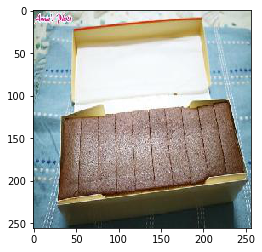

In [15]:
# Start training netwokr 

for ep in range(epoch):
    
    area,mask = choose_mask(generate_mask_list())  # 1 mask

  
    train_true,train_output  = generate_train_img(mask, area,src,ep,batch_size)
 
    H,W = train_true.shape[1:3]
    print ('here ??')
    label = create_label(batch_size,ch,H,W,n_layer=5)
    print ([l.shape for l in label])
    
    for it in range (iter):
        # for each img, train 50 times
        model.fit([train_output,train_true],label,epochs=50,verbose=1)
        model.save('4_layer_cnn_20_epoch')
        print ('epochs = ', ep, 'iter=', it,'model saved')


# After model saved, could do Inference


In [12]:
# choosing an image 

22 18 81 118


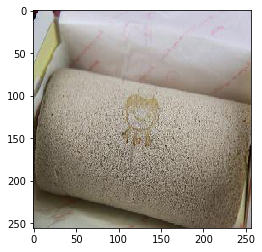

In [13]:
mask = np.zeros((256,256,3)).astype('uint8')
choose_mask = randint(0,9999)
x,y,w,h = mask_list[choose_mask]
print (x,y,w,h)
#mask[x:x+w,y:y+h,:]=255  


mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
plt.imshow(mask)

# save mask
cv2.imwrite(src+'mask'+str(pick)+'.png', mask)
mask_path = src+'mask'+str(pick)+'.png'


true_img_path =  src+'masked_img' +str(pick) + '.jpg'
true_img = cv2.imread(src+str(pick)+'.jpg')
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

#save asked image
masked_img = true_img.copy()
masked_img[mask > 0] = 255
cv2.imwrite(src+'masked_img'+str(pick)+'.jpg', masked_img)
masked_img_path = src+'masked_img'+str(pick)+'.jpg'
output_img_path= src+'output'+str(pick)+'.png'


# here should change ....too many times load model 
subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
--output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)

output_img =  cv2.imread(output_img_path)


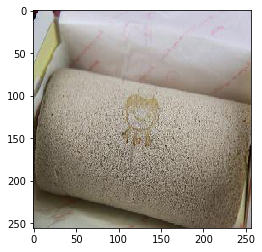

In [14]:
# show true image
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

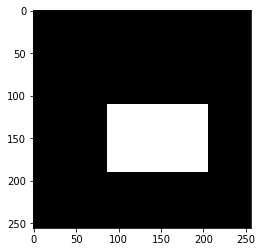

In [15]:
# show mask
plt.imshow(mask)

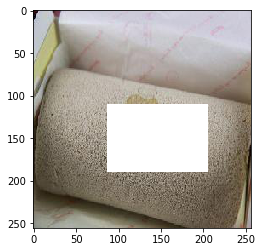

In [16]:
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

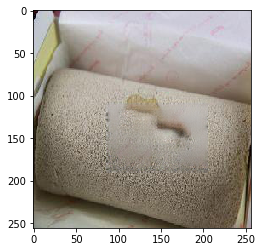

In [17]:
# show generated image
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

In [18]:
generated_img_area = output_img[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
generated_img_area = generated_img_area[np.newaxis,:,:,:]

print (generated_img_area.shape)

(1, 80, 118, 3)


In [11]:
# load model and do inference 
    
model = load_model('4_layer_cnn_20_epoch_multi_batch')

improved_area = model.predict ([generated_img_area]*2)

print (len(improved_area))
print (improved_area[-1].shape)
improved_img = np.squeeze(improved_area[-1])*255.
print (improved_img.shape)

OSError: Unable to open file (unable to open file: name = '4_layer_cnn_20_epoch_multi_batch', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
# replace masked area by Shape Free NN inference result
output_img2 =output_img.copy()
output_img2[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:] = improved_img

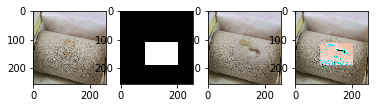

In [21]:
# show the final result 

f = plt.figure()
f.add_subplot(1,4, 1)
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

f.add_subplot(1,4, 3)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 4)
plt.imshow(cv2.cvtColor(output_img2, cv2.COLOR_BGR2RGB))

plt.show(block=True)
